# LSTM and Bidirectional LSTM Model
**MIDS W210 Capstone | Find Your Rhythm**

Database: mdb_idmt_egmd500 (all songs in mdb and idmt database, and 500 random songs from egmd database)

In [1]:
from google.cloud import storage

# Basic packages 
import pickle
import librosa
import IPython.display as ipd
import numpy as np
from os import listdir
import os
import sys
import math
import random

# Plot Package
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
from IPython.display import clear_output

# Model Package
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, Activation,LSTM, TimeDistributed, Bidirectional
from keras.regularizers import l2
from keras import callbacks
from keras.callbacks import History, ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report

## 1. Load Data and Lables

1. Create a function to load data from bucket to virtual machine
    * Bucket name: model_input_1
    * GCP_Folder in Bucket: mdb_idmt-only/
    * VM Folder Name: model_input/


In [2]:
def loadfile(bucket, gcp_filepath, VM_filepath):
    """
    Loads n a np file from GCP bucket storage to VM
    
    Inputs:
    bucket = str bucket name
    gcp_filepath = filepath to file in bucket
    VM_filepath = filepath in VM to store np data
    
    """
    from google.cloud import storage
    import pickle as pkl
    
    # create storage client
    storage_client = storage.Client()
    # get bucket with name
    bucket = storage_client.get_bucket(bucket)
    # get bucket data as blob
    blob = bucket.blob(gcp_filepath)
    
    with open(VM_filepath, "wb") as dest_file:
        blob.download_to_file(dest_file)
        


2. Use the below data arrays to train NN models to identify drum instrument onsets in unseen audio data
    * train_x.npy
    * train_y.npy
    * train_dict.pkl

    * val_x.npy
    * val_y.npy
    * val_dict.pkl

    * test_x.npy
    * test_y.npy
    * test_dict.pkl

In [3]:
def loadArrays(dataset='train', bucket=None, gcp_folder=None, VM_folder=None, LoadFile=False):
    """
    Inputs:
    dataset = 'train', 'val', or 'test'

    Outputs:
    arr_x = input data
    arr_y = input labels
    arr_dict = lookup dict {initial frame : song name}
    """

    datasets = {'train':['train_x.npy','train_y.npy','train_dict.pkl'],
              'val':['val_x.npy','val_y.npy','val_dict.pkl'],
              'test':['test_x.npy','test_y.npy','test_dict.pkl']}
    
    if LoadFile == True:
        for i in range(len(datasets[dataset])):
            loadfile(bucket, gcp_folder + datasets[dataset][i], VM_folder + datasets[dataset][i])
            

    arr_x = np.load(VM_folder + datasets[dataset][0])
    arr_y = np.load(VM_folder + datasets[dataset][1])
    with open(VM_folder + datasets[dataset][2], 'rb') as file:
        arr_dict = pickle.load(file)
    

    return arr_x, arr_y, arr_dict

In [4]:
os.makedirs('model_input/mdb_idmt_egmd500/', exist_ok=True)

x_train, y_train, train_dict = loadArrays('train', bucket='fyr-audio-data', gcp_folder='model_inputs/mdb_idmt_egmd500/', VM_folder='model_input/mdb_idmt_egmd500/')
x_val, y_val, val_dict = loadArrays('val', bucket='fyr-audio-data', gcp_folder='model_inputs/mdb_idmt_egmd500/', VM_folder='model_input/mdb_idmt_egmd500/')
x_test, y_test, test_dict = loadArrays('test', bucket='fyr-audio-data', gcp_folder='model_inputs/mdb_idmt_egmd500/', VM_folder='model_input/mdb_idmt_egmd500/')

print("x_train = ", np.array(x_train).shape)
print("y_train = ", np.array(y_train).shape)

print("x_val = ", np.array(x_val).shape)
print("y_val = ", np.array(y_val).shape)

print("x_test = ", np.array(x_test).shape)
print("y_test = ", np.array(y_test).shape)

x_train =  (374745, 1025)
y_train =  (374745, 19)
x_val =  (174150, 1025)
y_val =  (174150, 19)
x_test =  (82775, 1025)
y_test =  (82775, 19)


In [5]:
file_name = 'labels.pkl'
VM_folder = 'model_input/mdb_idmt_egmd500/'
gcp_folder='model_inputs/mdb_idmt_egmd500/'
loadfile('fyr-audio-data', gcp_folder + file_name,  VM_folder + file_name)
with open(VM_folder + file_name, 'rb') as file:
    dict_keys = pickle.load(file)
print(dict_keys)

[38, 35, 51, 42, 44, 37, 50, 43, 46, 54, 53, 49, 47, 39, 41, 56, 48, 52, 55]


In [6]:
test_dict

{0: 'raw-audio/eGMD/eGMD-wavfiles/drummer1_session1_191_reggae_78_fill_4-4_31.midi.wav',
 430: 'raw-audio/eGMD/eGMD-wavfiles/drummer1_session1_266_funk-purdieshuffle_130_fill_4-4_17.midi.wav',
 645: 'raw-audio/eGMD/eGMD-wavfiles/drummer1_session1_221_rock-halftime_140_fill_4-4_6.midi.wav',
 860: 'raw-audio/eGMD/eGMD-wavfiles/drummer1_session2_131_afrocuban-bembe_122_fill_4-4_18.midi.wav',
 2365: 'raw-audio/MDBDrums/MusicDelta_Shadows_Drum.wav',
 2580: 'raw-audio/eGMD/eGMD-wavfiles/drummer1_session1_114_funk_95_fill_4-4_58.midi.wav',
 3440: 'raw-audio/eGMD/eGMD-wavfiles/drummer1_session1_76_jazz-mediumfast_180_beat_4-4_51.midi.wav',
 7955: 'raw-audio/MDBDrums/MusicDelta_ModalJazz_Drum.wav',
 8170: 'raw-audio/eGMD/eGMD-wavfiles/drummer1_session1_237_rock-halftime_140_fill_4-4_32.midi.wav',
 8385: 'raw-audio/eGMD/eGMD-wavfiles/drummer1_session1_164_latin-brazilian-baiao_95_fill_4-4_41.midi.wav',
 8600: 'raw-audio/eGMD/eGMD-wavfiles/drummer1_session1_233_rock-halftime_140_fill_4-4_54.midi.

3. Check instrument index in labels

In [7]:
# Instrument pitch is ordered based on label counts collected in mdb and idmt database
midi_classes = {35: 'Acoustic Bass Drum', 36: 'Bass Drum 1', 37: 'Side Stick', 38: 'Acoustic Snare', 39: 'Hand Clap', 
                40: 'Electric Snare', 41: 'Low Floor Tom', 42: 'Closed Hi Hat', 43: 'High Floor Tom', 44: 'Pedal Hi-Hat', 
                45: 'Low Tom', 46: 'Open Hi-Hat', 47: 'Low-Mid Tom', 48: 'Hi-Mid Tom', 49: 'Crash Cymbal 1', 
                50: 'High Tom',  51: 'Ride Cymbal 1', 52: 'Chinese Cymbal', 53: 'Ride Bell', 54: 'Tambourine', 
                55: 'Splash Cymbal', 56: 'Cowbell', 57: 'Crash Cymbal 2', 58: 'Vibraslap', 59: 'Ride Cymbal 2', 
                60: 'Hi Bongo', 61: 'Low Bongo', 62: 'Mute Hi Conga', 63: 'Open Hi Conga', 64: 'Low Conga', 
                65: 'High Timbale', 66: 'Low Timbale', 67: 'High Agogo', 68: 'Low Agogo', 69: 'Cabasa', 
                70: 'Maracas', 71: 'Short Whistle', 72: 'Long Whistle', 73: 'Short Guiro', 74: 'Long Guiro', 
                75: 'Claves', 76: 'Hi Wood Block', 77: 'Low Wood Block', 78: 'Mute Cuica', 79: 'Open Cuica', 
                80: 'Mute Triangle', 81: 'Open Triangle',
               # to be removed
                22: 'Unknown 22', 26: 'Unknown 26'
               }

inst_labels = []
for inst_t in dict_keys:
    inst_labels.append(midi_classes[inst_t])
print(inst_labels)

['Acoustic Snare', 'Acoustic Bass Drum', 'Ride Cymbal 1', 'Closed Hi Hat', 'Pedal Hi-Hat', 'Side Stick', 'High Tom', 'High Floor Tom', 'Open Hi-Hat', 'Tambourine', 'Ride Bell', 'Crash Cymbal 1', 'Low-Mid Tom', 'Hand Clap', 'Low Floor Tom', 'Cowbell', 'Hi-Mid Tom', 'Chinese Cymbal', 'Splash Cymbal']


## 2. LSTM Model
### 2.1 LSTM Basic Model
1. Create a function (KerasSegmentGenerator) to cut frame to each time window (segment)
2. Transform train, validation and test data into shape size (batch size, segment length, frequency bins)
3. Train LSTM Model (7 labels:Acoustic Snare, Acoustic Bass Drum, Ride Cymbal 1, Closed Hi Hat, Pedal Hi-Hat, Side Stick, High Tom)

1. Create a PlotLosses function which is used in model training to show dynamic loss graph during training process

In [8]:
# Function to create a dynamic loss graph

class PlotLosses(callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.title('model binary entropy loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper right')
        plt.show();
        
plot_losses = PlotLosses()

2. Create a function (KerasSegmentGenerator) to cut frame to each time window (segment)

In [9]:
class KerasSegmentGenerator(object):
    def __init__(self, data, outcome, num_steps, num_features, num_class, skip_step=5):
        self.data = data  #Train, validation, test dataset
        self.outcome = outcome #Train, validation, test labels
        self.num_steps = num_steps  # segment length
        self.num_features = num_features # no of feature bins
        self.num_class = num_class  # no of different Drum Instruments (3 DIs)
        # this will track the progress of the batches sequentially through the
        # data set - once the data reaches the end of the data set it will reset
        # back to zero
        self.current_idx = 0  # track progress of batches, once dataset reaches the end, it resets to zero
        # THis determines overlap for two sequential segment, if skip step = num step, there is no overlap
        self.skip_step = skip_step

    def generate(self):
        """Output Train and Validation Dataset and Labels
        Train Dataset Dimentsion: Batch Size, Segment Length, no of frequency bin
        Train Label Dimension: Batch Size, Segment Length, no of drum instrument"""
        self.interations = int(len(self.data)/self.num_steps)
        self.x = np.zeros((self.interations, self.num_steps, self.num_features))
        self.y = np.zeros((self.interations, self.num_steps, self.num_class))
        
        while True:
            for i in range(self.interations):
                if self.current_idx + self.num_steps >= len(self.data):
                  # reset the index back to the start of the data set
                   self.current_idx = 0
                self.x[i, :, :] = self.data[self.current_idx:self.current_idx + self.num_steps]
                self.y[i, :, :] = self.outcome[self.current_idx:self.current_idx + self.num_steps]
                self.current_idx += self.skip_step
            return self.x, self.y

3. Transform train, validation and test data into shape size (batch size, segment length, frequency bins)

In [10]:
# npy arrays were created using segment length of 5 seconds
# convert 5 seconds into frames (npy arrays are in frames)
segmentLength = librosa.time_to_frames(5) 

# Number of drum instruments to study in model
n_inst = 7

train_segment_generator = KerasSegmentGenerator(x_train, y_train[:,0:n_inst], segmentLength, x_train.shape[1], y_train[:,0:n_inst].shape[1],
                                           skip_step=segmentLength)
val_segment_generator = KerasSegmentGenerator(x_val , y_val[:,0:n_inst], segmentLength, x_val.shape[1], y_val[:,0:n_inst].shape[1],
                                           skip_step=segmentLength)
test_segment_generator = KerasSegmentGenerator(x_test , y_test[:,0:n_inst], segmentLength, x_test.shape[1], y_test[:,0:n_inst].shape[1],
                                           skip_step=segmentLength)

trainx,trainy = train_segment_generator.generate()
valx,valy = val_segment_generator.generate()
testx,testy = test_segment_generator.generate()

print('Train dataset shape:', trainx.shape)
print('Train label shape:', trainy.shape)
print('Validation dataset shape:', valx.shape)
print('Validation label shape:', valy.shape)
print('Test dataset shape:', testx.shape)
print('Test label shape:', testy.shape)

Train dataset shape: (1743, 215, 1025)
Train label shape: (1743, 215, 7)
Validation dataset shape: (810, 215, 1025)
Validation label shape: (810, 215, 7)
Test dataset shape: (385, 215, 1025)
Test label shape: (385, 215, 7)


4. LSTM Model Training

In [12]:
os.makedirs('model_log', exist_ok=True)
File_Root = 'model_log/'

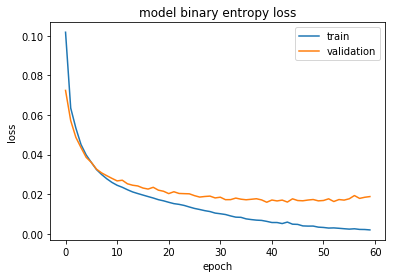

88/88 [==============================] - 113s 1s/step - binary_crossentropy: 0.0019 - loss: 0.0019 - val_loss: 0.0188 - val_binary_crossentropy: 0.0188
Epoch 00060: early stopping


In [13]:
'''###### TRAIN 1: LSTM - 2 layers - 500 unis per layer ######'''
   
database_name = 'mdb_idmt_egmd500'
number_units = 500
number_layers = 2
number_classes = trainy.shape[2]
num_epochs = 200
batch_size = 20

#Create a folder to restore the state and log file
weights_dir = File_Root + 'LSTM_%s_BatchSize_%i_Layers_%i_Nodes_%i_Classes_%i'%(database_name, batch_size, number_layers, number_units, number_classes)
if not os.path.exists(weights_dir):
    os.makedirs(weights_dir)


print ('Build model...')
model = Sequential()
history = History()

print("Adding 1st layer of {} units".format(number_units))
model.add(LSTM(units=number_units, input_shape=(segmentLength,trainx.shape[2],), return_sequences=True))
for i in range(number_layers-1):
    print ("Adding %d" % (i+2) + "th layer of %d" % number_units + " units")
    model.add(LSTM(number_units, return_sequences=True, activation='tanh'))
    # a dropout layer to prevent overfitting.
    model.add(Dropout(0.25))

print("Adding classification layer")
# TimeDistributed adds an independent layer for each time step in the recurrent model. 
model.add(TimeDistributed(Dense(number_classes)))
model.add(Activation('sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_crossentropy'])

checkpointer = ModelCheckpoint(filepath= weights_dir + '/model-{epoch:02d}.hdf5', verbose=1, save_best_only=True)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, mode='auto')

training_log = open(weights_dir + "/Training.log", "w")
print ('Train . . .')
# let's say you have an ImageNet generat        print "Fitting the batch :"
save = model.fit(trainx, trainy, batch_size = batch_size, validation_data=(valx, valy), epochs = num_epochs, verbose=1,callbacks=[checkpointer, early, plot_losses])
training_log.write(str(save.history) + "\n")
training_log.close()

5. Event Segmentation Method and Model Evaluation

In [14]:
database_name = 'mdb_idmt_egmd500'
number_units = 500
number_layers = 2
number_classes = trainy.shape[2]
num_epochs = 200
batch_size = 20

#Create a folder to restore the state and log file
weights_dir = File_Root + 'LSTM_%s_BatchSize_%i_Layers_%i_Nodes_%i_Classes_%i'%(database_name, batch_size, number_layers, number_units, number_classes)
model = load_model(weights_dir + "/model-40.hdf5")
# model.summary()
print("Evaluate on test data")
results = model.evaluate(testx, testy, batch_size=20)
print("test loss, test acc:", results)
prediction = model.predict(testx)
Threshold = 0.7
prediction[prediction>Threshold] = 1
prediction[prediction<=Threshold] = 0

for i in range(prediction.shape[0]):
    if i == 0:
        prediction_concat = prediction[i, :, :]
        testy_concat = testy[i, :, :]
    else:
        prediction_concat = np.concatenate((prediction_concat,prediction[i, :, :]))
        testy_concat = np.concatenate((testy_concat,testy[i, :, :]))
    
    

from sklearn.metrics import classification_report
print(classification_report(testy_concat, prediction_concat, target_names=inst_labels[0:trainy.shape[2]]))

Evaluate on test data
20/20 [==============================] - 8s 387ms/step - binary_crossentropy: 0.0308 - loss: 0.0308
test loss, test acc: [0.030810387805104256, 0.030810387805104256]
                    precision    recall  f1-score   support

    Acoustic Snare       0.91      0.65      0.76      2663
Acoustic Bass Drum       0.89      0.84      0.87      1810
     Ride Cymbal 1       0.86      0.75      0.80      2132
     Closed Hi Hat       0.91      0.66      0.77      2203
      Pedal Hi-Hat       0.92      0.65      0.76      1324
        Side Stick       0.98      0.89      0.94       639
          High Tom       0.93      0.79      0.85       305

       avg / total       0.90      0.72      0.80     11076



In [17]:
model = load_model(weights_dir + "/model-40.hdf5")
# model.summary()
print("Evaluate on test data")
results = model.evaluate(testx, testy, batch_size=20)
print("test loss, test acc:", results)
prediction = model.predict(testx)
# Threshold = 0.9
# prediction[prediction>Threshold] = 1
# prediction[prediction<=Threshold] = 0

for i in range(prediction.shape[0]):
    if i == 0:
        prediction_concat = prediction[i, :, :]
        testy_concat = testy[i, :, :]
    else:
        prediction_concat = np.concatenate((prediction_concat,prediction[i, :, :]))
        testy_concat = np.concatenate((testy_concat,testy[i, :, :]))
        


rate_lst = [20]

for t in rate_lst:
    T = t*np.mean(prediction_concat,axis = 0)
    predicts =  np.zeros(prediction_concat.shape)
    print(T)
    for i in range(prediction_concat.shape[0]):
        for j in range(prediction_concat.shape[1]):
            if (i != 0) and (i != prediction_concat.shape[0]-1):
                if (prediction_concat[i][j]>prediction_concat[i-1][j]) and (prediction_concat[i][j]>=prediction_concat[i+1][j]) and (prediction_concat[i][j]>T[j]):
                    predicts[i][j] = 1
                else:
                    predicts[i][j] = 0
            else:
                predicts[i][j] = 0
    
    

    from sklearn.metrics import classification_report
    print(classification_report(testy_concat, predicts, target_names=inst_labels[0:trainy.shape[2]]))

Evaluate on test data
20/20 [==============================] - 8s 399ms/step - binary_crossentropy: 0.0308 - loss: 0.0308
test loss, test acc: [0.030810387805104256, 0.030810387805104256]
[0.5385193  0.4488132  0.48858458 0.49967942 0.2616413  0.15043058
 0.06851204]
                    precision    recall  f1-score   support

    Acoustic Snare       0.89      0.69      0.78      2663
Acoustic Bass Drum       0.88      0.86      0.87      1810
     Ride Cymbal 1       0.85      0.77      0.81      2132
     Closed Hi Hat       0.90      0.74      0.81      2203
      Pedal Hi-Hat       0.83      0.67      0.74      1324
        Side Stick       0.96      0.95      0.96       639
          High Tom       0.88      0.89      0.88       305

       avg / total       0.88      0.76      0.81     11076



6. Separate prediction by songs and store true and predicted onset array separated by songs in 'testy_output.pkl' and 'predict_output.pkl'

**Note:** The format is a dictionary: {song name: onset array}**

In [49]:
Start_Frame = list(test_dict.keys())
Start_Frame.sort()
frame_index = 0
predict_output_dict = {}
testy_output_dict = {}
while frame_index < (len(Start_Frame)):
    if frame_index == (len(Start_Frame)-1):
        predict_output_dict[test_dict[Start_Frame[frame_index]]] = predicts[Start_Frame[frame_index]:]
        testy_output_dict[test_dict[Start_Frame[frame_index]]] = testy_concat[Start_Frame[frame_index]:]
    else:
        predict_output_dict[test_dict[Start_Frame[frame_index]]] = predicts[Start_Frame[frame_index]:Start_Frame[frame_index+1]]
        testy_output_dict[test_dict[Start_Frame[frame_index]]] = testy_concat[Start_Frame[frame_index]:Start_Frame[frame_index+1]]
    frame_index += 1

In [50]:
OutputFile_Root = 'model_output/'
output_folder = OutputFile_Root + 'LSTM_%s_BatchSize_%i_Layers_%i_Nodes_%i_Classes_%i/'%(database_name, batch_size, number_layers, number_units, number_classes)
os.makedirs(output_folder, exist_ok=True)


with open( output_folder + 'testy_output.pkl', 'wb') as file:
    pickle.dump(testy_output_dict, file)
    
with open( output_folder + 'predict_output.pkl', 'wb') as file:
    pickle.dump(predict_output_dict, file)

6. plots for prediction and true onset comparison

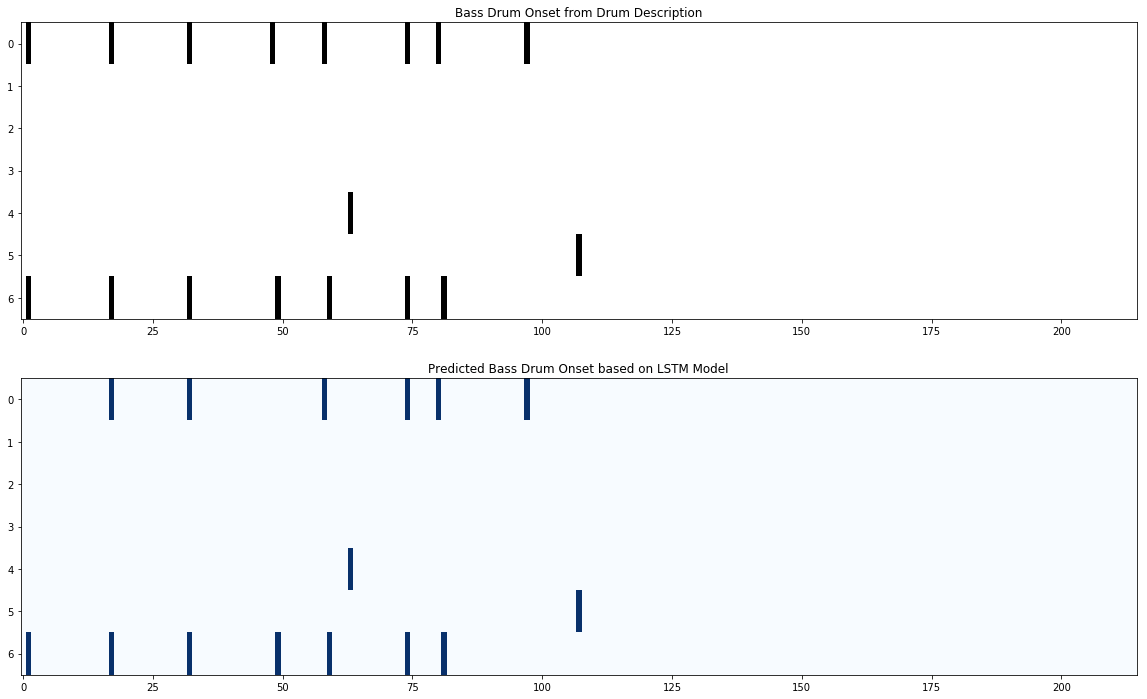

In [51]:
a = testy_output_dict['raw-audio/eGMD/eGMD-wavfiles/drummer1_session1_205_rock-halftime_140_fill_4-4_25.midi.wav']
b = predict_output_dict['raw-audio/eGMD/eGMD-wavfiles/drummer1_session1_205_rock-halftime_140_fill_4-4_25.midi.wav']
fig, axes = plt.subplots(2,1, figsize=(20,12))
axes[0].set_title('Bass Drum Onset from Drum Description')
axes[0].imshow(a.transpose(),cmap='Greys',aspect='auto', interpolation = 'nearest')
# axes[0].set_xticklabels(range(4950,5250,50))

axes[1].set_title('Predicted Bass Drum Onset based on LSTM Model')
axes[1].imshow(b.transpose(),cmap='Blues',aspect='auto', interpolation = 'nearest')
# axes[1].set_xticklabels(range(4950,5250,50))

In [52]:
print(classification_report(a, b, target_names=inst_labels[0:7]))


                    precision    recall  f1-score   support

    Acoustic Snare       1.00      0.75      0.86         8
Acoustic Bass Drum       0.00      0.00      0.00         0
     Ride Cymbal 1       0.00      0.00      0.00         0
     Closed Hi Hat       0.00      0.00      0.00         0
      Pedal Hi-Hat       1.00      1.00      1.00         1
        Side Stick       1.00      1.00      1.00         1
          High Tom       1.00      1.00      1.00         7

       avg / total       1.00      0.88      0.93        17



/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[Text(0, 0, '4950'),
 Text(0, 0, '5000'),
 Text(0, 0, '5050'),
 Text(0, 0, '5100'),
 Text(0, 0, '5150'),
 Text(0, 0, '5200')]

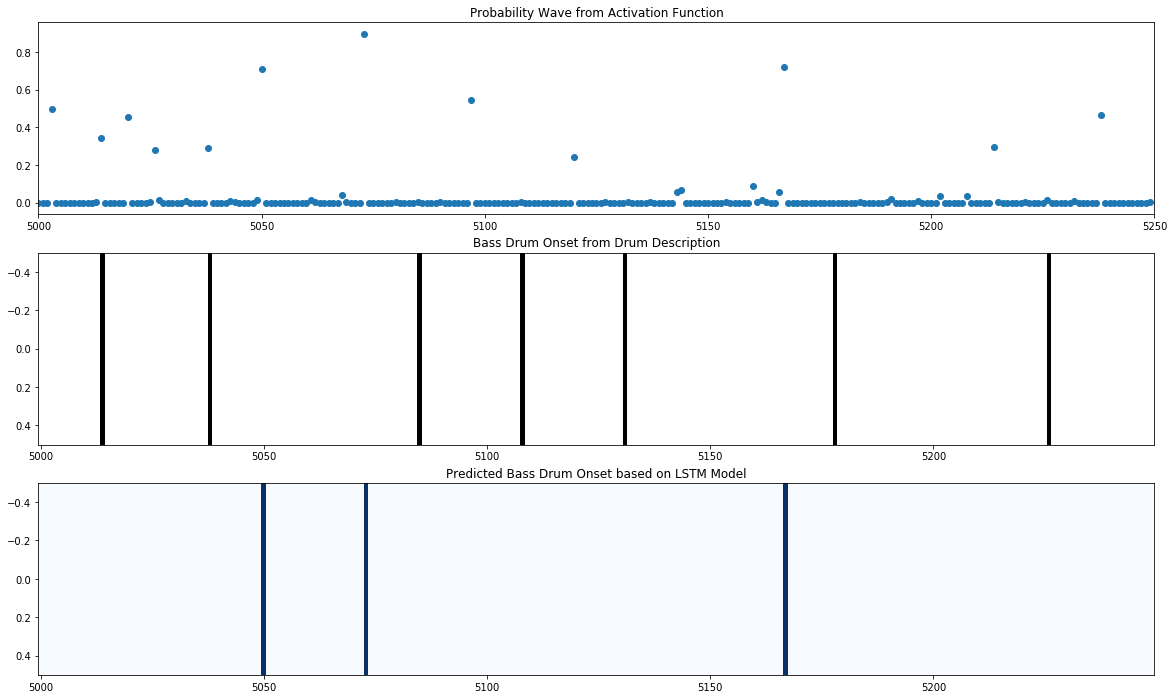

In [36]:
fig, axes = plt.subplots(3,1, figsize=(20,12))

axes[0].set_title('Probability Wave from Activation Function')
axes[0].scatter(x=range(5000,5250), y=prediction_concat[5000:5250,0])
axes[0].set_xlim(5000,5250)



## 2.2 Bidirectional LSTM Model
Acoustic Snare, Acoustic Bass Drum, Ride Cymbal 1, Closed Hi Hat, Pedal Hi-Hat, Side Stick, High Tom

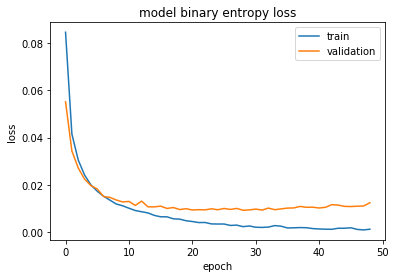

88/88 [==============================] - 274s 3s/step - loss: 0.0011 - binary_crossentropy: 0.0011 - val_binary_crossentropy: 0.0123 - val_loss: 0.0123
Epoch 00049: early stopping


In [13]:
'''###### TRAIN 2: Bidirectional LSTM - 2 layers - 500 unis per layer ######'''
   
database_name = 'mdb_idmt_egmd500'
number_units = 500
number_layers = 2
number_classes = trainy.shape[2]
num_epochs = 200
batch_size = 20

#Create a folder to restore the state and log file
weights_dir = File_Root + 'BiLSTM_%s_BatchSize_%i_Layers_%i_Nodes_%i_Classes_%i'%(database_name, batch_size, number_layers, number_units, number_classes)
if not os.path.exists(weights_dir):
    os.makedirs(weights_dir)


print ('Build model...')
model = Sequential()
history = History()

print("Adding 1st layer of {} units".format(number_units))
model.add(Bidirectional(LSTM(units=number_units, input_shape=(segmentLength,trainx.shape[2],), return_sequences=True)))
for i in range(number_layers-1):
    print ("Adding %d" % (i+2) + "th layer of %d" % number_units + " units")
    model.add(Bidirectional(LSTM(number_units, return_sequences=True, activation='tanh')))
    # a dropout layer to prevent overfitting.
    model.add(Dropout(0.25))

print("Adding classification layer")
# TimeDistributed adds an independent layer for each time step in the recurrent model. 
model.add(TimeDistributed(Dense(number_classes)))
model.add(Activation('sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_crossentropy'])

checkpointer = ModelCheckpoint(filepath= weights_dir + '/model-{epoch:02d}.hdf5', verbose=1, save_best_only=True)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, mode='auto')

training_log = open(weights_dir + "/Training.log", "w")
print ('Train . . .')
# let's say you have an ImageNet generat        print "Fitting the batch :"
save = model.fit(trainx, trainy, batch_size = batch_size, validation_data=(valx, valy), epochs = num_epochs, verbose=1,callbacks=[checkpointer, early, plot_losses])
training_log.write(str(save.history) + "\n")
training_log.close()

In [15]:
model = load_model(weights_dir + "/model-29.hdf5")
# model.summary()
print("Evaluate on test data")
results = model.evaluate(testx, testy, batch_size=20)
print("test loss, test acc:", results)
prediction = model.predict(testx)
# Threshold = 0.9
# prediction[prediction>Threshold] = 1
# prediction[prediction<=Threshold] = 0

for i in range(prediction.shape[0]):
    if i == 0:
        prediction_concat = prediction[i, :, :]
        testy_concat = testy[i, :, :]
    else:
        prediction_concat = np.concatenate((prediction_concat,prediction[i, :, :]))
        testy_concat = np.concatenate((testy_concat,testy[i, :, :]))
        


rate_lst = [20]

for t in rate_lst:
    T = t*np.mean(prediction_concat,axis = 0)
    predicts =  np.zeros(prediction_concat.shape)
    print(T)
    for i in range(prediction_concat.shape[0]):
        for j in range(prediction_concat.shape[1]):
            if (i != 0) and (i != prediction_concat.shape[0]-1):
                if (prediction_concat[i][j]>prediction_concat[i-1][j]) and (prediction_concat[i][j]>=prediction_concat[i+1][j]) and (prediction_concat[i][j]>T[j]):
                    predicts[i][j] = 1
                else:
                    predicts[i][j] = 0
            else:
                predicts[i][j] = 0
    
    

    from sklearn.metrics import classification_report
    print(classification_report(testy_concat, predicts, target_names=inst_labels[0:trainy.shape[2]]))

Evaluate on test data
20/20 [==============================] - 12s 617ms/step - loss: 0.0190 - binary_crossentropy: 0.0190
test loss, test acc: [0.01904096081852913, 0.019040964543819427]
[0.5987224  0.4469642  0.4616865  0.53795224 0.24821995 0.1530766
 0.07400401]
                    precision    recall  f1-score   support

    Acoustic Snare       0.95      0.84      0.90      2663
Acoustic Bass Drum       0.91      0.92      0.91      1810
     Ride Cymbal 1       0.92      0.83      0.87      2132
     Closed Hi Hat       0.91      0.87      0.89      2203
      Pedal Hi-Hat       0.92      0.72      0.80      1324
        Side Stick       0.97      0.95      0.96       639
          High Tom       0.92      0.95      0.94       305

       avg / total       0.93      0.85      0.89     11076



Temperary Completed Point

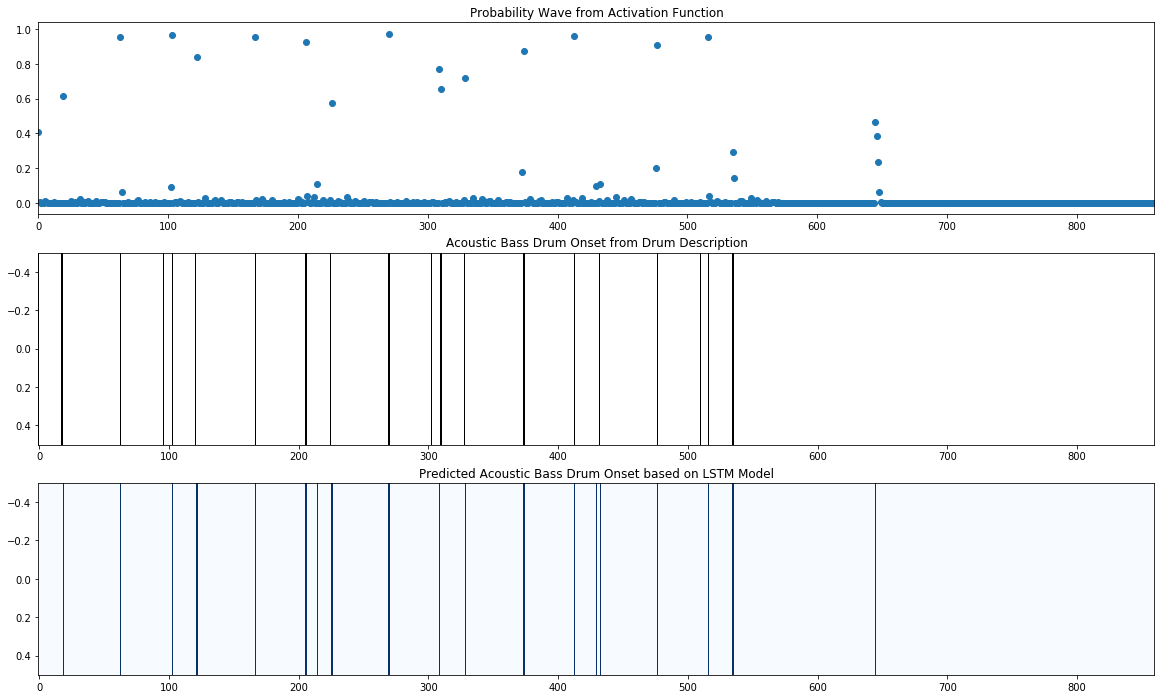

In [61]:
fig, axes = plt.subplots(3,1, figsize=(20,12))

ints_idx = 1

axes[0].set_title('Probability Wave from Activation Function')
axes[0].scatter(x=range(0,860), y=prediction_concat[0:860,ints_idx])
axes[0].set_xlim(0,860)

axes[1].set_title('%s Onset from Drum Description'% (inst_labels[ints_idx]))
axes[1].imshow(y_test[0:860,ints_idx:ints_idx+1].transpose(),cmap='Greys',aspect='auto', interpolation = 'nearest')
# axes[1].set_xticklabels(range(4950,5250,50))

axes[2].set_title('Predicted %s Onset based on LSTM Model'% (inst_labels[ints_idx]))
axes[2].imshow(predicts[0:860,ints_idx:ints_idx+1].transpose(),cmap='Blues',aspect='auto', interpolation = 'nearest')
# axes[2].set_xticklabels(range(4950,5250,50))

[Text(0, 0, ''),
 Text(0, 0, 'Closed Hi Hat'),
 Text(0, 0, 'Acoustic Bass Drum'),
 Text(0, 0, 'Acoustic Snare')]

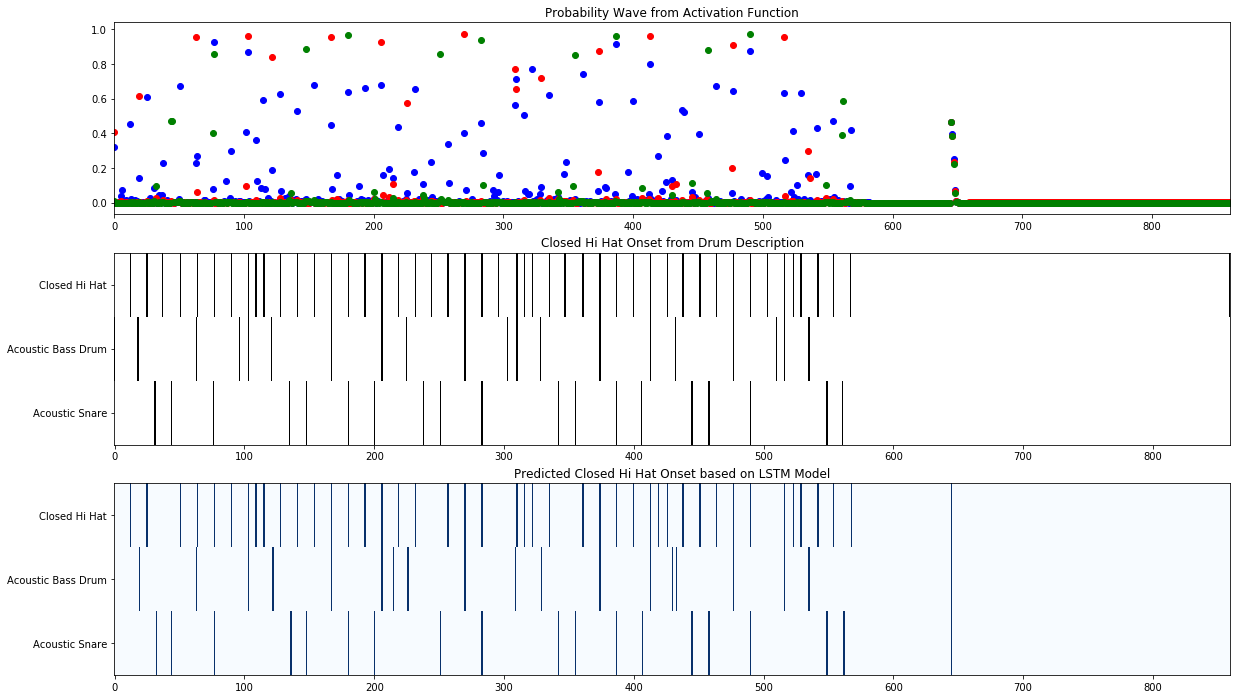

In [75]:
fig, axes = plt.subplots(3,1, figsize=(20,12))

ints_idx = 0
ints_no = 3

axes[0].set_title('Probability Wave from Activation Function')
axes[0].scatter(x=range(0,860), y=prediction_concat[0:860,ints_idx], c=['blue'])
axes[0].scatter(x=range(0,860), y=prediction_concat[0:860,ints_idx+1], c=['red'])
axes[0].scatter(x=range(0,860), y=prediction_concat[0:860,ints_idx+2], c=['green'])
axes[0].set_xlim(0,860)

axes[1].set_title('%s Onset from Drum Description'% (inst_labels[ints_idx]))
axes[1].imshow(y_test[0:860,ints_idx:ints_idx+ints_no].transpose(),cmap='Greys',aspect='auto', interpolation = 'nearest')
axes[1].locator_params(axis='y', nbins=ints_no)
axes[1].set_yticklabels([''] + inst_labels[ints_idx:ints_idx+3])


axes[2].set_title('Predicted %s Onset based on LSTM Model'% (inst_labels[ints_idx]))
axes[2].imshow(predicts[0:860,ints_idx:ints_idx+ints_no].transpose(),cmap='Blues',aspect='auto', interpolation = 'nearest')
axes[2].locator_params(axis='y', nbins=ints_no)
axes[2].set_yticklabels([''] + inst_labels[ints_idx:ints_idx+3])

## 2.3 LSTM Model with 3 Drum Instrument
'Closed Hi Hat', 'Acoustic Bass Drum', 'Acoustic Snare'

In [15]:
# npy arrays were created using segment length of 5 seconds
# convert 5 seconds into frames (npy arrays are in frames)
segmentLength = librosa.time_to_frames(5) 

# Number of drum instruments to study in model
n_inst = 3

train_segment_generator = KerasSegmentGenerator(x_train, y_train[:,0:n_inst], segmentLength, x_train.shape[1], y_train[:,0:n_inst].shape[1],
                                           skip_step=segmentLength)
val_segment_generator = KerasSegmentGenerator(x_val , y_val[:,0:n_inst], segmentLength, x_val.shape[1], y_val[:,0:n_inst].shape[1],
                                           skip_step=segmentLength)
test_segment_generator = KerasSegmentGenerator(x_test , y_test[:,0:n_inst], segmentLength, x_test.shape[1], y_test[:,0:n_inst].shape[1],
                                           skip_step=segmentLength)

trainx,trainy = train_segment_generator.generate()
valx,valy = val_segment_generator.generate()
testx,testy = test_segment_generator.generate()

print('Train dataset shape:', trainx.shape)
print('Train label shape:', trainy.shape)
print('Validation dataset shape:', valx.shape)
print('Validation label shape:', valy.shape)
print('Test dataset shape:', testx.shape)
print('Test label shape:', testy.shape)

Train dataset shape: (347, 215, 1025)
Train label shape: (347, 215, 3)
Validation dataset shape: (178, 215, 1025)
Validation label shape: (178, 215, 3)
Test dataset shape: (76, 215, 1025)
Test label shape: (76, 215, 3)


In [77]:
'''###### TRAIN 1: LSTM - 2 layers - 500 unis per layer ######'''
   
number_units = 500
number_layers = 2
number_classes = trainy.shape[2]
num_epochs = 200
batch_size = 20
File_Root = 'model_log/'

#Create a folder to restore the state and log file
weights_dir = File_Root + 'LSTM_BatchSize_%i_Layers_%i_Nodes_%i_Classes_%i'%(batch_size, number_layers, number_units, number_classes)
if not os.path.exists(weights_dir):
    os.makedirs(weights_dir)


print ('Build model...')
model = Sequential()
history = History()

print("Adding 1st layer of {} units".format(number_units))
model.add(LSTM(units=number_units, input_shape=(segmentLength,trainx.shape[2],), return_sequences=True))
for i in range(number_layers-1):
    print ("Adding %d" % (i+2) + "th layer of %d" % number_units + " units")
    model.add(LSTM(number_units, return_sequences=True, activation='tanh'))
    # a dropout layer to prevent overfitting.
    model.add(Dropout(0.25))

print("Adding classification layer")
# TimeDistributed adds an independent layer for each time step in the recurrent model. 
model.add(TimeDistributed(Dense(number_classes)))
model.add(Activation('sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_crossentropy'])

checkpointer = ModelCheckpoint(filepath= weights_dir + '/model-{epoch:02d}.hdf5', verbose=1, save_best_only=True)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, mode='auto')

training_log = open(weights_dir + "/Training.log", "w")
print ('Train . . .')
# let's say you have an ImageNet generat        print "Fitting the batch :"
save = model.fit(trainx, trainy, batch_size = batch_size, validation_data=(valx, valy), epochs = num_epochs, verbose=1,callbacks=[checkpointer, early])
training_log.write(str(save.history) + "\n")
training_log.close()

Build model...
Adding 1st layer of 500 units
Adding 2th layer of 500 units
Adding classification layer
Train . . .
Epoch 1/200
18/18 [==============================] - ETA: 0s - binary_crossentropy: 0.2041 - loss: 0.2041
Epoch 00001: val_loss improved from inf to 0.11770, saving model to model_log/LSTM_BatchSize_20_Layers_2_Nodes_500_Classes_3/model-01.hdf5
18/18 [==============================] - 29s 2s/step - binary_crossentropy: 0.2041 - loss: 0.2041 - val_loss: 0.1177 - val_binary_crossentropy: 0.1177
Epoch 2/200
18/18 [==============================] - ETA: 0s - binary_crossentropy: 0.1204 - loss: 0.1204
Epoch 00002: val_loss improved from 0.11770 to 0.08636, saving model to model_log/LSTM_BatchSize_20_Layers_2_Nodes_500_Classes_3/model-02.hdf5
18/18 [==============================] - 29s 2s/step - binary_crossentropy: 0.1204 - loss: 0.1204 - val_loss: 0.0864 - val_binary_crossentropy: 0.0864
Epoch 3/200
18/18 [==============================] - ETA: 0s - binary_crossentropy: 0.088

In [16]:
number_units = 500
number_layers = 2
number_classes = trainy.shape[2]
num_epochs = 200
batch_size = 20
File_Root = 'model_log/'

weights_dir = File_Root + 'LSTM_BatchSize_%i_Layers_%i_Nodes_%i_Classes_%i'%(batch_size, number_layers, number_units, number_classes)
model = load_model(weights_dir + "/model-15.hdf5")
# model.summary()
print("Evaluate on test data")
results = model.evaluate(testx, testy, batch_size=20)
print("test loss, test acc:", results)
prediction = model.predict(testx)
# Threshold = 0.9
# prediction[prediction>Threshold] = 1
# prediction[prediction<=Threshold] = 0

for i in range(prediction.shape[0]):
    if i == 0:
        prediction_concat = prediction[i, :, :]
        testy_concat = testy[i, :, :]
    else:
        prediction_concat = np.concatenate((prediction_concat,prediction[i, :, :]))
        testy_concat = np.concatenate((testy_concat,testy[i, :, :]))
        


rate_lst = [6, 1, 1.7, 8, 8]
T=[]

for i in range(trainy.shape[2]):
    T.append(rate_lst[i]*np.mean(prediction_concat[:,i],axis = 0))
print(T)
    
    
predicts =  np.zeros(prediction_concat.shape)

for i in range(prediction_concat.shape[0]):
    for j in range(prediction_concat.shape[1]):
        if (i != 0) and (i != prediction_concat.shape[0]-1):
            if (prediction_concat[i][j]>prediction_concat[i-1][j]) and (prediction_concat[i][j]>=prediction_concat[i+1][j]) and (prediction_concat[i][j]>T[j]):
                predicts[i][j] = 1
            else:
                predicts[i][j] = 0
        else:
            predicts[i][j] = 0
    
    

from sklearn.metrics import classification_report
print(classification_report(testy_concat, predicts, target_names=inst_labels[0:trainy.shape[2]]))

Evaluate on test data
4/4 [==============================] - 1s 272ms/step - loss: 0.0650 - binary_crossentropy: 0.0650
test loss, test acc: [0.0650162473320961, 0.0650162398815155]
[0.2579520419239998, 0.04315447062253952, 0.04207566156983376]
                    precision    recall  f1-score   support

     Closed Hi Hat       0.62      0.70      0.66       662
Acoustic Bass Drum       0.59      0.70      0.64       707
    Acoustic Snare       0.51      0.77      0.62       392

       avg / total       0.58      0.72      0.64      1761



## 3. Upload File to Bucket

In [12]:
def writeGcpFile(bucket, gcp_filepath, local_filepath):
    """
    Writes a file to GCP bucket storage
    
    Inputs:
    auth_json = str path to service account json auth file
    bucket = str bucket name
    gcp_filepath = str filepath to file in bucket
    local_filepath = str filepath to local file
    
    Outputs:
    prints a statement showing successful file upload to gcp_filepath
    """
    from google.cloud import storage
    
    # create storage client
    storage_client = storage.Client()
    # get bucket with name
    bucket = storage_client.bucket(bucket)
    # write local file to GCP
    blob = bucket.blob(gcp_filepath)
    
    # use gsutil command to write file using multi-threading
    #!gsutil -m cp {local_filepath} gs://{bucket}/{gcp_filepath}
    
    blob.upload_from_filename(local_filepath)

    print('File {} uploaded to {}.'.format(
            local_filepath.split('/')[-1],
            gcp_filepath)
         )

In [22]:
from google.cloud import storage
import os
import logging
def writeGcpFile(gcs_project_id, target_bucket_name, bucket_folder, filename):
        '''upload CSV to file in GCS

        Args:
            gcs_project_id (str): project name
            target_bucket_name (str): name of GCS bucket
            bucket_folder (str): name of GCS folder
            filename (str): filepath to upload

        Returns:
            nothing. Side effect is that data is uploaded to GCS

        '''
        storage_client = storage.Client(gcs_project_id)
        bucket = storage_client.get_bucket(target_bucket_name)
        path = bucket_folder + os.sep + filename
        logging.info("Loading to GCS: %s", path)
        blob = bucket.blob(path) #name in GCS
        blob.upload_from_filename('model_log/LSTM_mdb_idmt_egmd500_BatchSize_20_Layers_2_Nodes_500_Classes_7/'+filename) 


In [24]:

writeGcpFile(gcs_project_id='find-your-rhythm', target_bucket_name='fyr-audio-data', bucket_folder='model_output/mdb_idmt_egmd500/', filename='model-40.hdf5')

Forbidden: 403 POST https://storage.googleapis.com/upload/storage/v1/b/fyr-audio-data/o?uploadType=resumable: ('Request failed with status code', 403, 'Expected one of', <HTTPStatus.OK: 200>)